In [70]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def read_csv_data(folder_path: str) -> pd.DataFrame:
    """Combines multiple CSV files in a folder into a single DataFrame,
    creating a new column for each file's "close" values, using "Date" as the index,
    and renaming columns based on filenames with character adjustments.

    Args:
        folder_path (str): Path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: Combined DataFrame with "Date" index and renamed columns.
    """

    all_data = pd.DataFrame()
    csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]  # List CSV files with os.listdir()

    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            df = df[['Date', 'close']] 
            df = df.set_index('Date')  # Set Date as index

            # Renaming and character removal using os.path.basename()
            filename = os.path.basename(csv_file) 
            clean_filename = re.sub(r"[^\w]", "", filename.split('.')[0])  # Remove non-alphanumeric characters
            df.columns = [clean_filename]

            all_data = pd.concat([all_data, df], axis=1)  # Concatenate horizontally (by columns)
            # all_data = all_data.fillna(0)
        except Exception as e:
            print(f"Error reading file {csv_file}: {e}")

    
    return all_data


In [71]:
import scipy.optimize as sco

#CONSTANT
TRADING_DAYS_PER_YEAR = 365 #crypto is 24/7

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *TRADING_DAYS_PER_YEAR
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(TRADING_DAYS_PER_YEAR)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate, num_assets):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

def display_calculated_ef_with_random(token_df, portoflio_value, mean_returns, log_returns, cov_matrix, risk_free_rate, permutation=50):
    num_assets = token_df.shape[1]
    results, _ = random_portfolios(portoflio_value,mean_returns, cov_matrix, risk_free_rate, num_assets)
    
    # Max sharpe ratio
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=token_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    # Min volatility
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=token_df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualized Return:", round(rp,2))
    print ("Annualized Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualized Return:", round(rp_min,2))
    print ("Annualized Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    
    print ("-"*80)
    an_vol = np.std(log_returns, axis=0) * np.sqrt(TRADING_DAYS_PER_YEAR)
    an_rt = mean_returns * TRADING_DAYS_PER_YEAR
    print ("Individual Coin Returns and Volatility\n")
    for i, txt in enumerate(token_df.columns):
        print (txt,":","Annualized return",round(an_rt.iloc[i],2),", Annualized volatility:",round(an_vol.iloc[i],2))
    print ("-"*80) 
    
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='plasma', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, rp, permutation)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)
    
    # weights saved on x
    #pprint(efficient_portfolios["x"])    
    
    #fig, ax = plt.subplots(figsize=(10, 7))
    plt.scatter(an_vol,an_rt,marker='o',s=200)
    for i, txt in enumerate(token_df.columns):
        plt.annotate(txt, (an_vol.iloc[i],an_rt.iloc[i]), xytext=(10,0), textcoords='offset points')


## Read Ticker Datasets

Read datasets from "Data" Folder. In this method we will use close price and assume any missing values as '0'.

Text(0, 0.5, 'price in $')

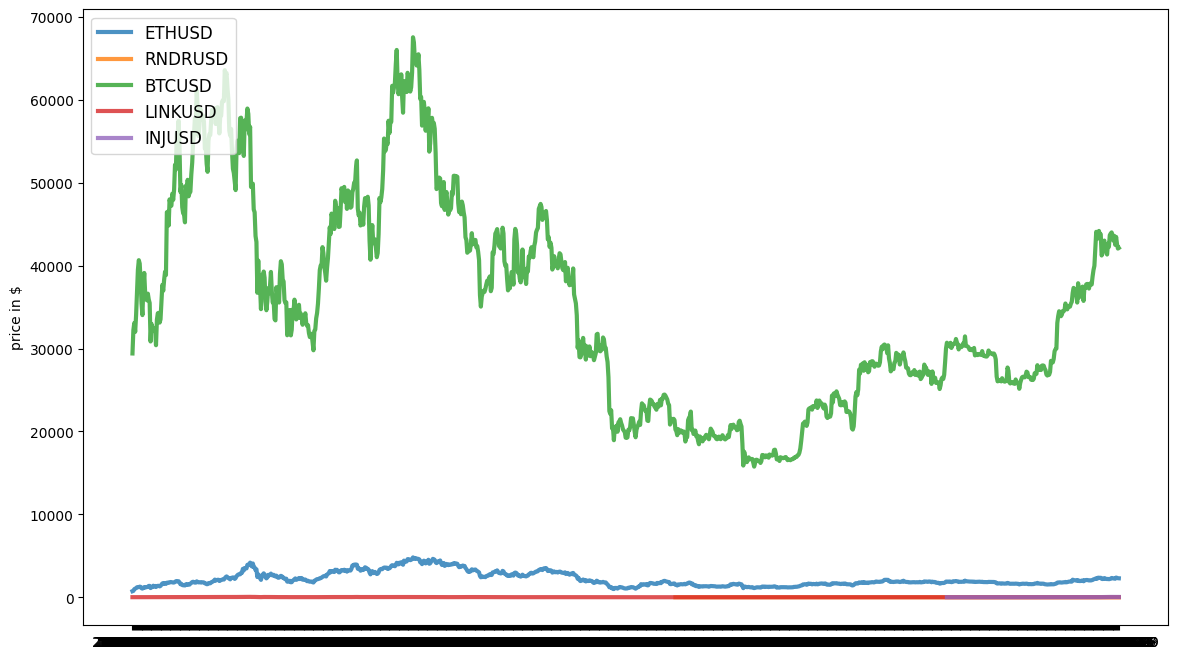

In [72]:
total_portfolio = 15000
ticker_data = read_csv_data("data")  
num_assets = ticker_data.shape[1]
mean_daily_ret = ticker_data.pct_change(1).mean()
mean_daily_ret # not sure if this can be used later

plt.figure(figsize=(14, 8))
for c in ticker_data.columns.values:
    plt.plot(ticker_data.index, ticker_data[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')


## Log Returns vs Arithmetic Returns

We will now switch over to using log returns instead of arithmetic returns, for many of our use cases they are almost the same,but most technical analyses require detrending/normalizing the time series and using log returns is a nice way to do that.
Log returns are convenient to work with in many of the algorithms we will encounter.

For a full analysis of why we use log returns, check [this great article](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).


Text(0, 0.5, 'daily returns')

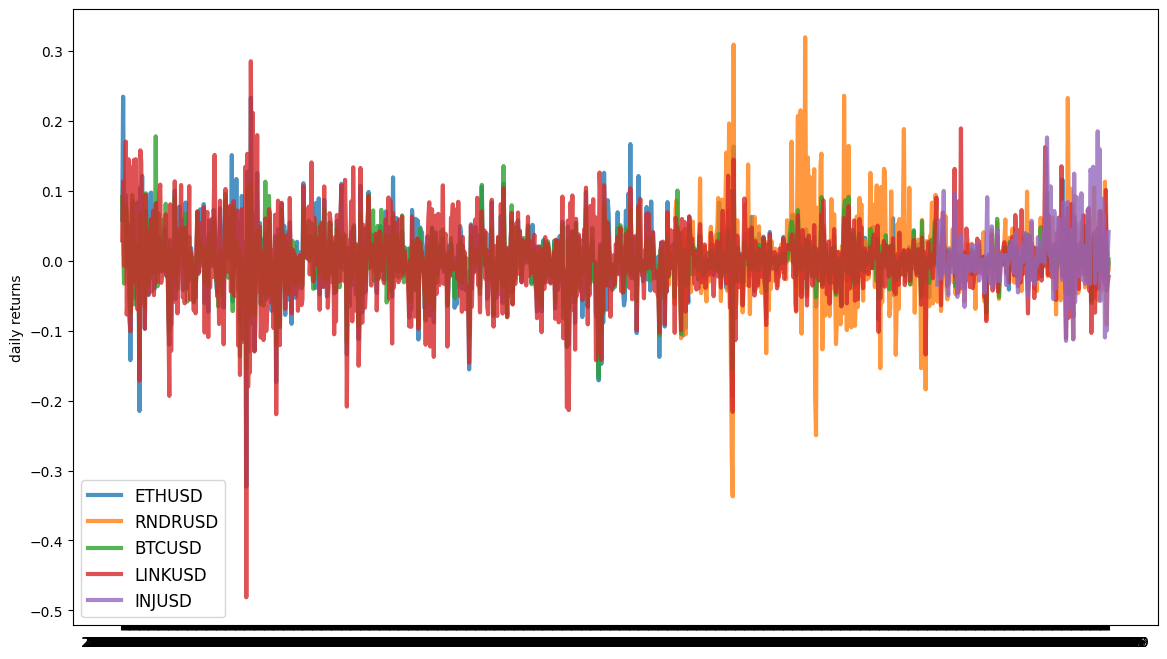

In [73]:
log_ret = np.log(ticker_data/ticker_data.shift(1))
log_ret.head()

log_returns = log_ret
mean_returns = log_returns.mean() #* trading_days_per_year
cov_matrix = log_returns.cov()

plt.figure(figsize=(14, 8))
for c in log_returns.columns.values:
    plt.plot(log_returns.index, log_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(fontsize=12)
plt.ylabel('daily returns')

## Minimization on Randomized Portfolios - 1st Method

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 3.08
Annualized Volatility: 0.88


            ETHUSD  RNDRUSD  BTCUSD  LINKUSD  INJUSD
allocation     0.0     6.31     0.0      0.0   93.69
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 1.01
Annualized Volatility: 0.59


            ETHUSD  RNDRUSD  BTCUSD  LINKUSD  INJUSD
allocation     0.0      0.0    71.0      0.0    29.0
--------------------------------------------------------------------------------
Individual Coin Returns and Volatility

ETHUSD : Annualized return 0.38 , Annualized volatility: 0.85
RNDRUSD : Annualized return 1.62 , Annualized volatility: 1.23
BTCUSD : Annualized return 0.12 , Annualized volatility: 0.65
LINKUSD : Annualized return 0.08 , Annualized volatility: 1.1
INJUSD : Annualized return 3.18 , Annualized volatility: 0.91
--

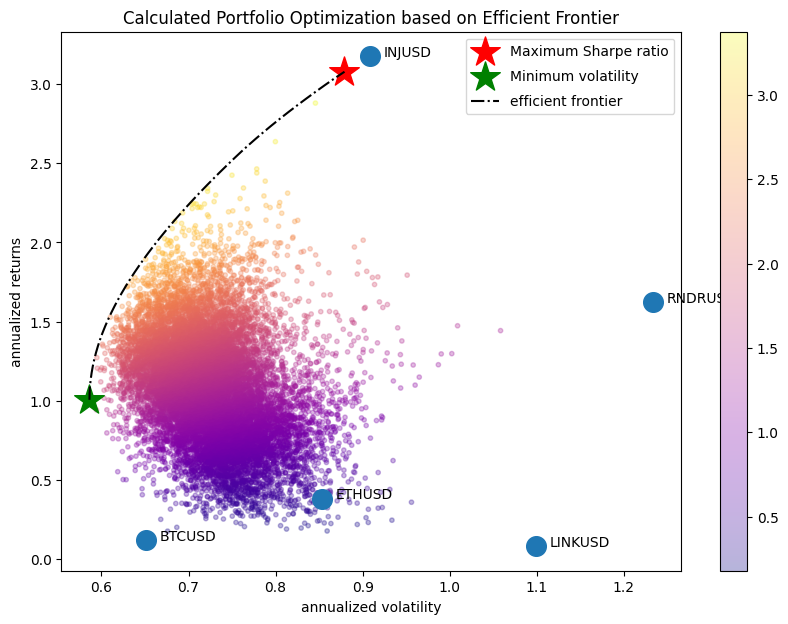

In [74]:
display_calculated_ef_with_random(ticker_data, total_portfolio, mean_returns, log_returns, cov_matrix, risk_free_rate=0.0245, permutation=50)

## Minimization on Randomized Portfolios - 2nd Method

In [83]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * TRADING_DAYS_PER_YEAR
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * TRADING_DAYS_PER_YEAR, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 


In [76]:
# Set seed (optional)
np.random.seed(101)

# Crypto Columns
print('Coins')
print(ticker_data.columns)

# Create Random Weights
print('Creating Random Weights')
weights = np.array(np.random.random(num_assets))
print(weights)
print('\n')

# Rebalance Weights
print('Rebalance to sum to 1.0')
weights = weights / np.sum(weights)
print(weights)
print('\n')

# Expected Return
print('Expected Portfolio Return')
exp_ret = np.sum(log_ret.mean() * weights) * TRADING_DAYS_PER_YEAR
print(exp_ret)
print('\n')

# Expected Variance
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * TRADING_DAYS_PER_YEAR, weights)))
print(exp_vol)
print('\n')

# Sharpe Ratio
SR = exp_ret/exp_vol
print('Sharpe Ratio')
print(SR)

Coins
Index(['ETHUSD', 'RNDRUSD', 'BTCUSD', 'LINKUSD', 'INJUSD'], dtype='object')
Creating Random Weights
[0.51639863 0.57066759 0.02847423 0.17152166 0.68527698]


Rebalance to sum to 1.0
[0.26182041 0.28933544 0.01443678 0.08696357 0.3474438 ]


Expected Portfolio Return
1.6820265412526665


Expected Volatility
0.7216982287300717


Sharpe Ratio
2.3306507821315092


In [77]:
num_ports = 15000
all_coins = ticker_data.columns.tolist()

# Set seed (optional)
np.random.seed(101)

all_weights = np.zeros((num_ports,len(ticker_data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(num_assets))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *TRADING_DAYS_PER_YEAR)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * TRADING_DAYS_PER_YEAR, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

max_SR = sharpe_arr.max()
print("Max Sharpe Ratio:", max_SR)

agent_index = sharpe_arr.argmax()
print("Max Sharpe Ratio index:", agent_index)

allocation_res = all_weights[agent_index,:]
print("Optimum allocation:")

for asset, allocation in zip(all_coins, allocation_res):
    print('{}:{:.2f}'.format(asset, allocation))
print('\n')

max_sr_ret = ret_arr[agent_index]
max_sr_vol = vol_arr[agent_index]
print("Max return: ", max_sr_ret)
print("Max volatility: ", max_sr_vol)
print('\n')

# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = tuple((0,1) for i in range(num_assets))

# Initial Guess (equal distribution)
init_guess = [1/num_assets for i in range(num_assets)]

# Sequential Least SQuares Programming (SLSQP).
opt_results = sco.minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

results = get_ret_vol_sr(opt_results.x)
results

Max Sharpe Ratio: 3.4283967834739166
Max Sharpe Ratio index: 12723
Optimum allocation:
ETHUSD:0.02
RNDRUSD:0.11
BTCUSD:0.02
LINKUSD:0.03
INJUSD:0.83


Max return:  2.8283647120771307
Max volatility:  0.8249817307351494




array([3.07421474, 0.87821806, 3.50051414])

# All Optimal Portfolios (Efficient Frontier)

The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have a higher level of risk for the defined rate of return.

Efficient Frontier http://www.investopedia.com/terms/e/efficientfrontier

            ETHUSD  RNDRUSD  BTCUSD  LINKUSD  INJUSD
allocation    0.02     0.11    0.02     0.03    0.83


Max return:  2.8283647120771307
Max volatility:  0.8249817307351494


Shape arr:


12723

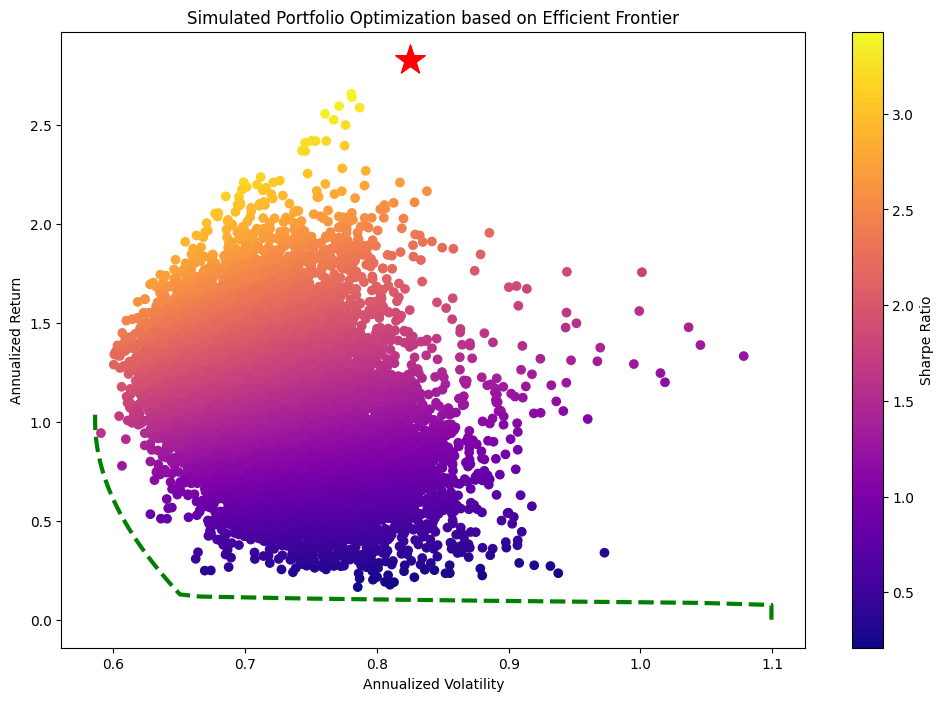

In [82]:
return_val = get_ret_vol_sr(opt_results.x)[1]

# Our returns go from 0 to somewhere along max return
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,return_val * 1.2 ,100) # Change 100 to a lower number for slower computers!

frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = sco.minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

allocation_dict = {}
for asset, allocation in zip(all_coins, allocation_res):
    allocation_dict[asset] = round(allocation,2)
    
allocation_df = pd.DataFrame(allocation_dict, index =["allocation"])
print(allocation_df)
print('\n')
print("Max return: ", max_sr_ret)
print("Max volatility: ", max_sr_vol)
print('\n')

plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,marker='*', c='red',s=500,label='Maximum Sharpe ratio')


# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

print("Shape arr:")
sharpe_arr.argmax()